<div style="display: flex; background-color: RGB(255,114,0); padding: 30px;" >

# Weather
</div>
by : Ellande, Vincent et Aurélie

<div style="display: flex; background-color: Blue; padding: 15px;" >

## 0.Mission 
</div>

Une appli internationale de météo vous engage pour vérifier s'il est possible de détecter et classer de manière **non supervisée** la catégorie météo d'un jeu d'images (sachant que la détectation de manière supervisée avec CNN peuve fournir de très bons résultats). Voici les 4 catégories :
- rain 🌧, 
- cloudy ☁️, 
- sunshine ☀️, 
- sunrise 🌅.

Vous décidez de réaliser un pré-traitement d'images de type SIFT / ORB / SURF de génération de descripteurs et de "bag of visual words" afin de créer un histogramme par image. Vous réaliserez une réduction de dimension de type T-SNE et afficherez un graphique T-SNE des images selon leur catégories.

Vous vérifierez ainsi la faisabilité de séparer les images météo selon le type de météo. Avant de tester avec toutes les images à la disposition de l’appli, vous décidez de tester la faisabilité sur un dataset de 400 images déjà catégorisées. Vous en avez 100 par catégorie.

<div style="display: flex; background-color: Blue; padding: 15px;" >

## 1.Chargement des données
</div>

In [1]:
from os import getcwd
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from collections import defaultdict
import re
from vae_weather import *

In [2]:
# ---------------------------------------------------------------------------------------------
#                               MAIN
# ---------------------------------------------------------------------------------------------
verbose = False
force_reloading = True

# Récupère le répertoire du programme
file_path = getcwd() + "\\"
file_path

'c:\\Users\\User\\WORK\\workspace-ia\\PROJETS\\vae_weather_picture\\'

In [3]:
source_data_path = file_path+"dataset\\"
print("Source path :", source_data_path)

Source path : c:\Users\User\WORK\workspace-ia\PROJETS\vae_weather_picture\dataset\


<div style="display: flex; background-color: Green; padding: 7px;" >

### Liste des images à récupérer
</div>

In [4]:
# récupération données
img_extensions = [".jpg", ".jpeg", ".png"]
images = []

for ext in img_extensions:
    images.extend(get_dir_files(source_data_path, endwith=ext))

print(len(images), "images")

400 images


In [ ]:
demo_img = source_data_path + images[0]
demo_img

'c:\\Users\\User\\WORK\\workspace-ia\\PROJETS\\vae_weather_picture\\dataset\\cloudy1.jpg'

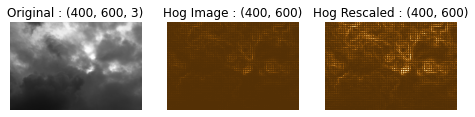

In [108]:
img_cloudy, resized_img_cloudy, hog_image_cloudy = show_hog(img_path=demo_img)

<div style="display: flex; background-color: Blue; padding: 15px;" >

## 1.Créations des descripteurs de chaque image 
</div>

1. Pour chaque image passage en gris et equalisation

2. création d'une liste de descripteurs par image ("sift_keyspoints_img") qui sera utilisée pour réaliser les histogrammes par image

3. création d'une liste de descripteurs pour l'ensemble des images ("sift_keyspoints_all_imag") qui sera utilisé pour créer les clusters de descripteurs (on vera çe on détaille  aprés)

In [5]:
nb_descriptors=500

Descripteurs :  (74, 128)


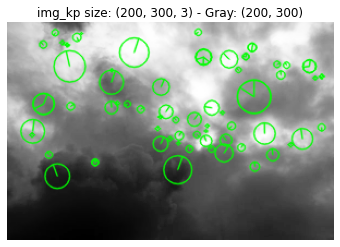

In [107]:
demo_kp, demo_des, demo_img_kp = transform_kp(demo_img, scale_percent=50)

In [6]:
img_dic = defaultdict(list)
img_descriptors_dic = defaultdict(list)
sift_keyspoints_img=[]
sift_keyspoints_all_img = []

src_images = images.copy()

pattern = get_regex_alphabetique_simple()
nb_img_without_desc = 0
for img_path in src_images:
    try:
        _, _, descriptor = define_img_point(source_data_path+img_path, nb_descriptors=nb_descriptors, display=False, verbose=verbose)
        if descriptor is not None:
            img_dic["file_name"].append(img_path)
            name = img_path.lower().split(".")[0]
            name = re.sub(pattern, '', name).strip()
            img_dic["y"].append(name)
            sift_keyspoints_img.append(descriptor)
            img_descriptors_dic[img_path] = descriptor
            sift_keyspoints_all_img.extend(descriptor)
        else:
            if verbose>1:
                print(f"{img_path} as no Descriptor : {descriptor}")
            nb_img_without_desc += 1
            images.remove(img_path)
    except Exception as error:
        print("ERROR : ", img_path)
        print(error)
    
print(f"{nb_img_without_desc} images sans descripteurs sur {len(src_images)} images au départ, soit {len(images)} images restantes")
print(len(sift_keyspoints_all_img), len(sift_keyspoints_all_img[0]))

0 images sans descripteurs sur 400 images au départ, soit 400 images restantes
150144 128


In [7]:
df_origin = pd.DataFrame.from_dict(img_dic)
print(df_origin.shape)
df_origin.columns

(400, 2)


Index(['file_name', 'y'], dtype='object')

In [8]:
df_origin['y'].value_counts()

cloudy     100
rain       100
shine      100
sunrise    100
Name: y, dtype: int64

<div style="display: flex; background-color: Blue; padding: 15px;" >

## 2.Version supervisée
</div>

In [9]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder

<div style="display: flex; background-color: Green; padding: 7px;" >

### 2.1. Encodage de la target
</div>

In [10]:
df_origin["y_label"] = df_origin["y"] 
label_encoder = LabelEncoder()
df_origin["y"] =  label_encoder.fit_transform(df_origin["y_label"])
species = df_origin["y"].sort_values().unique()
print(species)
df_origin.head()

[0 1 2 3]


,file_name,y,y_label
0,cloudy1.jpg,0,cloudy
1,cloudy10.jpg,0,cloudy
2,cloudy100.jpg,0,cloudy
3,cloudy11.jpg,0,cloudy
4,cloudy12.jpg,0,cloudy


<div style="display: flex; background-color: Green; padding: 7px;" >

### 2.2. Clustering des descripteurs
</div>

In [11]:
print(len(sift_keyspoints_all_img))
n_clusters = round(np.sqrt(len(sift_keyspoints_all_img)))
n_clusters

150144


387

In [12]:
batch_size = len(images) * 3
kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, verbose=verbose).fit(sift_keyspoints_all_img)

<div style="display: flex; background-color: Green; padding: 7px;" >

### 2.3. Creation of the histograms
</div>

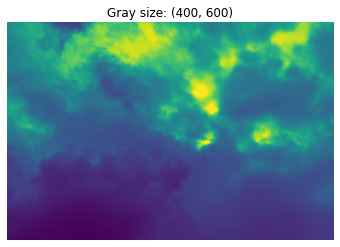

In [104]:
img_cloudy_gray = cv2.imread(demo_img, 0)
plt.imshow(img_cloudy_gray)
plt.title(f'Gray size: {img_cloudy_gray.shape}') 
plt.axis('off')
plt.show()

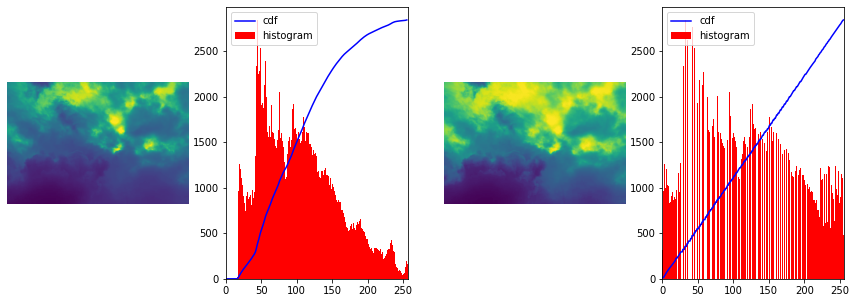

In [105]:
# Visualisation d'un histogramme
cloudy_equalize = show_histogramme(img_cloudy_gray, equalize=True)


In [13]:
histo_list = []

for img_path in images:
    try:
        _, histo = predict(n_clusters, kmeans, descriptor=img_descriptors_dic[img_path], verbose=verbose)
        histo_list.append(histo)
    except Exception as error:
        print("ERROR : ", img_path)
        print(error)

<div style="display: flex; background-color: Green; padding: 7px;" >

### 2.4. Training of the neural network
</div>

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
random_state=0
X_src = np.array(histo_list)
Y_src = df_origin["y"].to_list()
print(X_src.shape, len(Y_src))

(400, 387) 400


In [16]:
X, x_test_split, Y, y_test_split = train_test_split(X_src, Y_src, test_size=0.2, random_state=random_state)

<div style="display: flex; background-color: indigo;" >

#### 2.4.1. MLPClassifier
</div>

In [17]:
mlp = MLPClassifier(verbose=verbose, random_state=random_state, max_iter=600000)
mlp.fit(X, Y)
print(f"Train: {mlp.score(X, Y)}")
mlp.score(x_test_split, y_test_split) # 0.65 - randomstate 0 / 0.6375  - randomstate 42

Train: 1.0


0.6125

<div style="display: flex; background-color: indigo;" >

#### 2.4.2. SVC
</div>

In [18]:
from sklearn import svm

In [19]:
# Sans labelEncodeur : 0.89
# Avec LabelEncodeur : 0.87
sv = svm.SVC(random_state=random_state)
sv.fit(X, Y)
print(f"Train: {sv.score(X, Y)}")
sv.score(x_test_split, y_test_split)

Train: 0.8875


0.5875

<div style="display: flex; background-color: Green; padding: 7px;" >

### 2.5. Prédictions
</div>

In [20]:
df_src_dict, histo_list = pred_df(source_data_path, images, n_clusters, kmeans, mlp, species, label_encoder=label_encoder,img_descriptors_dic=img_descriptors_dic, file_name="predict_source.csv")

In [21]:
df_src = pd.DataFrame(df_src_dict)
df_src

,picture,target,predict,cloudy_proba_0,rain_proba_1,shine_proba_2,sunrise_proba_3
0,cloudy1.jpg,cloudy,cloudy,0.98,0.00,0.02,0.00
1,cloudy10.jpg,cloudy,shine,0.23,0.00,0.76,0.00
2,cloudy100.jpg,cloudy,cloudy,0.89,0.05,0.05,0.01
3,cloudy11.jpg,cloudy,cloudy,0.90,0.03,0.07,0.00
4,cloudy12.jpg,cloudy,cloudy,0.86,0.02,0.11,0.01
...,...,...,...,...,...,...,...
395,sunrise96.jpg,sunrise,sunrise,0.00,0.00,0.06,0.94
396,sunrise97.jpg,sunrise,sunrise,0.00,0.00,0.00,1.00
397,sunrise98.jpg,sunrise,sunrise,0.00,0.00,0.00,1.00
398,sunrise99.jpg,sunrise,sunrise,0.00,0.00,0.00,1.00


In [22]:
source_data_test_path = source_data_path.replace("dataset", "dataset_test")

# récupération données
images_test = []

for ext in img_extensions:
    images_test.extend(get_dir_files(source_data_test_path, endwith=ext))

print(len(images_test), "images")
images_test[::3]

62 images


['cloudy002.jpg',
 'cloudy005.jpg',
 'cloudy008.jpg',
 'cloudy011.jpg',
 'cloudy014.jpg',
 'rain003.jpg',
 'rain006.jpg',
 'rain009.jpg',
 'rain012.jpg',
 'rain015.jpg',
 'shine003.jpg',
 'shine006.jpg',
 'shine009.jpg',
 'shine012.jpg',
 'shine015.jpg',
 'sunrise003.jpg',
 'sunrise007.jpg',
 'sunrise010.jpg',
 'sunrise013.jpg',
 'sunrise016.jpg',
 'rain015.jpeg']

In [23]:
img_descriptors_test_dic = defaultdict(list)

for img_path in images_test:
    try:
        _, _, descriptor = define_img_point(source_data_test_path+img_path, nb_descriptors=nb_descriptors, display=False, verbose=verbose)       
        img_descriptors_test_dic[img_path] = descriptor
    except Exception as error:
        print("ERROR : ", img_path)
        print(error)

In [24]:
df_test_dict, histo_test_list = pred_df(source_data_test_path, images_test, n_clusters, kmeans, mlp, species, img_descriptors_dic=img_descriptors_test_dic, label_encoder=label_encoder, file_name="predict_test.csv")
df_test = pd.DataFrame(df_test_dict)
df_test["y"] = label_encoder.transform(df_test["target"])
df_test

,picture,target,predict,cloudy_proba_0,rain_proba_1,shine_proba_2,sunrise_proba_3,y
0,cloudy002.jpg,cloudy,cloudy,0.96,0.00,0.00,0.04,0
1,cloudy003.jpg,cloudy,shine,0.41,0.00,0.59,0.00,0
2,cloudy004.jpg,cloudy,cloudy,0.93,0.03,0.03,0.01,0
3,cloudy005.jpg,cloudy,cloudy,0.94,0.00,0.00,0.05,0
4,cloudy006.jpg,cloudy,sunrise,0.05,0.02,0.18,0.74,0
...,...,...,...,...,...,...,...,...
57,sunrise016.jpg,sunrise,shine,0.00,0.04,0.67,0.29,3
58,cloudy001.jpeg,cloudy,sunrise,0.01,0.00,0.02,0.97,0
59,rain002.jpeg,rain,shine,0.00,0.34,0.60,0.06,1
60,rain015.jpeg,rain,sunrise,0.00,0.01,0.01,0.98,1


In [25]:
X_test = np.array(histo_test_list)
Y_test = np.array(df_test["y"])
X_test.shape

(62, 387)

In [26]:
# Sans label encoder : 0.53
# Avec label encoder : 0.52 => images récupérées d'internet
# Avec label encoder : 
round(mlp.score(X_test, Y_test), 2)

0.45

In [27]:
# Sans label Encoder 0.46774193548387094
# Avec label Encoder 0.532258064516129
round(sv.score(X_test, Y_test), 2)

0.5

In [28]:
df_test[df_test["target"]!=df_test["predict"]]

,picture,target,predict,cloudy_proba_0,rain_proba_1,shine_proba_2,sunrise_proba_3,y
1,cloudy003.jpg,cloudy,shine,0.41,0.00,0.59,0.00,0
4,cloudy006.jpg,cloudy,sunrise,0.05,0.02,0.18,0.74,0
8,cloudy010.jpg,cloudy,shine,0.00,0.00,1.00,0.00,0
9,cloudy011.jpg,cloudy,sunrise,0.05,0.03,0.36,0.56,0
13,cloudy015.jpg,cloudy,shine,0.03,0.01,0.96,0.00,0
19,rain007.jpg,rain,sunrise,0.00,0.03,0.00,0.97,1
20,rain008.jpg,rain,sunrise,0.00,0.25,0.08,0.67,1
21,rain009.jpg,rain,sunrise,0.01,0.25,0.00,0.74,1
22,rain010.jpg,rain,sunrise,0.00,0.00,0.00,1.00,1
23,rain011.jpg,rain,sunrise,0.00,0.00,0.00,1.00,1


In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [30]:
cf_m = confusion_matrix(df_test['y'], label_encoder.transform(df_test['predict']))
df_confusion = pd.DataFrame(cf_m)
df_confusion

,0,1,2,3
0,9,0,3,3
1,0,8,1,7
2,7,2,5,1
3,2,4,4,6


In [31]:
df_confusion["expected"] = ""
for i in range(0, 4):
    label = label_encoder.inverse_transform([i])[0]
    df_confusion.loc[i,"expected"] = label_encoder.inverse_transform([i])[0]
    df_confusion = df_confusion.rename(columns={i:label})

df_confusion = df_confusion.set_index("expected")
df_confusion

,cloudy,rain,shine,sunrise
expected,,,,
cloudy,9,0,3,3
rain,0,8,1,7
shine,7,2,5,1
sunrise,2,4,4,6


<AxesSubplot:ylabel='expected'>

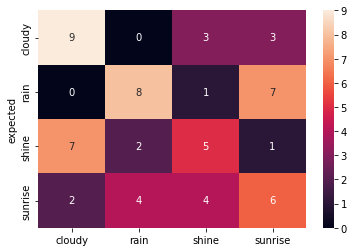

In [32]:
sns.heatmap(df_confusion, annot=True)

<div style="display: flex; background-color: Green; padding: 7px;" >

### 2.6. Analyse
</div>

Il y a un gros écart entre le score sur le train et le score sur le test.
Nous générons donc la courbe d'apprentissage pour avoir une vision de l'apprentissage du modèle

<div style="display: flex; background-color: Green; padding: 7px;" >

### 2.7. Learning Curve
</div>

In [ ]:
# cellule pour éviter de lancer le traitement par erreur
Just to fail

In [37]:
from sklearn.model_selection import learning_curve

[ 38  76 114 152 190 228 266 304 342 380]


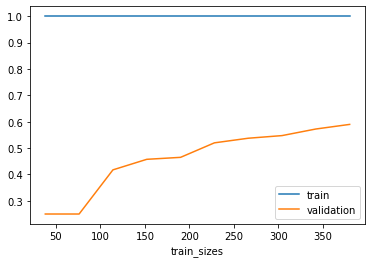

In [38]:
N, train_score, val_score = learning_curve(mlp, X_src, Y_src,
                                           train_sizes=np.linspace(0.1, 1, 10), cv=20)
print(N)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

In [39]:
X_FULL = X_src.copy()
Y_FULL = Y_src.copy()

df_X_completed = np.concatenate((X_src, X_test))
df_Y_completed = np.concatenate((Y_src, Y_test))
print(df_X_completed.shape)
print(df_Y_completed.shape)

(462, 387)
(462,)


[ 43  87 131 175 219 262 306 350 394 438]


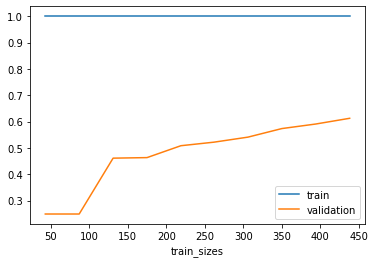

In [40]:
N, train_score, val_score = learning_curve(mlp, df_X_completed, df_Y_completed,
                                           train_sizes=np.linspace(0.1, 1, 10), cv=20)
print(N)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

<div style="display: flex; background-color: indigo;" >

#### Analyse
</div>

Sur les 2 courbes d'apprentissage précédentes, on voit qu'il y a un problème d'apprentissage, car le score du train reste à 1.          
Le modèle ne sait donc pas qu'il n'a pas correctement appris.         
Essai avec d'autres modèles pour voir s'il s'agit d'un soucis de sélection du modèle ou d'un manque de données ou les deux.

[ 43  87 131 175 219 262 306 350 394 438]


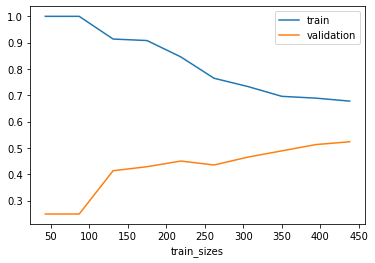

In [42]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
N, train_score, val_score = learning_curve(model, df_X_completed, df_Y_completed,
                                           train_sizes=np.linspace(0.1, 1, 10), cv=20)

print(N)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

[ 38  76 114 152 190 228 266 304 342 380]


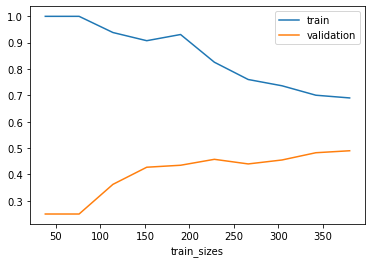

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
N, train_score, val_score = learning_curve(model, X_src, Y_src,
                                           train_sizes=np.linspace(0.1, 1, 10), cv=20)

print(N)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

[ 43  87 131 175 219 262 306 350 394 438]


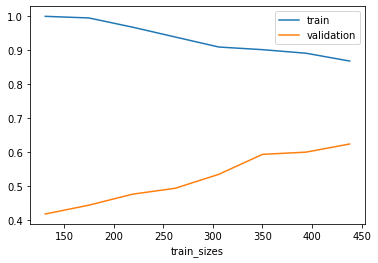

In [43]:
N, train_score, val_score = learning_curve(sv, df_X_completed, df_Y_completed,
                                           train_sizes=np.linspace(0.1, 1, 10), cv=20)
print(N)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

<div style="display: flex; background-color: indigo;" >

#### Analyse
</div>

Ces 2 modèles semblent plus pertinents, cependant nous notons qu'il manque également des données pour obtenir des résulats satisfaisants.

<div style="display: flex; background-color: Blue; padding: 15px;" >

## 8.ACP
</div>

Utilisation de l'ACP pour réduire les données

In [33]:
from sklearn import decomposition
from sklearn import preprocessing

In [34]:
# selection des colonnes à prendre en compte dans l'ACP
df_centre_reduit = pd.DataFrame(X.copy())
print("{:_} NAN".format(df_centre_reduit.isna().sum().sum()))
df_centre_reduit.shape

0 NAN


(320, 387)

In [35]:
df_centre_reduit.shape[1]

387

In [36]:
# must be between 0 and min(n_samples, n_features)=320 with svd_solver='full'
# choix du nombre de composantes à calculer
ACP_NB_COMPOSANTES = 320

# préparation des données pour l'ACP
X_acp = df_centre_reduit.values
names = df_centre_reduit.index # ou data.index pour avoir les intitulés
features = df_centre_reduit.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X_acp)
X_scaled = std_scale.transform(X_acp)

# calculer les composantes principales
pca = decomposition.PCA(n_components=ACP_NB_COMPOSANTES)
x_projeected = pca.fit_transform(X_scaled)
pd.DataFrame(x_projeected, index=df_centre_reduit.index, columns=["F"+str(i+1) for i in range(ACP_NB_COMPOSANTES)])

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F311,F312,F313,F314,F315,F316,F317,F318,F319,F320
0,1.964869,-4.290546,-2.531062,0.421926,-1.733097,-0.024717,-0.860963,-1.705541,-0.986893,-1.966318,...,0.026583,-0.247727,0.111839,2.353618e-15,1.110160e-19,9.410784e-18,3.112572e-18,2.726959e-17,3.533417e-19,1.472685e-20
1,-3.971259,-5.987972,1.117064,1.568000,-4.531402,0.761957,0.622539,-1.671289,5.363007,0.483224,...,0.063909,-0.047894,-0.040416,2.353618e-15,1.110160e-19,9.410784e-18,3.112572e-18,2.726959e-17,3.533417e-19,1.472685e-20
2,-9.131885,-1.515514,-1.837617,-0.986601,-2.510514,1.533475,0.742312,1.052235,2.190562,0.735271,...,0.113219,0.020109,0.066252,2.353618e-15,1.110160e-19,9.410784e-18,3.112572e-18,2.726959e-17,3.533417e-19,1.472685e-20
3,4.862218,5.557494,-0.124147,-0.119182,2.249912,1.078662,-1.786923,-1.476395,-0.742902,-0.325030,...,0.139793,0.048605,-0.005242,2.353618e-15,1.110160e-19,9.410784e-18,3.112572e-18,2.726959e-17,3.533417e-19,1.472685e-20
4,4.120370,0.748979,5.914169,-3.271797,0.548411,1.957564,-1.793425,-2.294677,1.275212,-1.069637,...,-0.040042,-0.038455,0.107403,2.353618e-15,1.110160e-19,9.410784e-18,3.112572e-18,2.726959e-17,3.533417e-19,1.472685e-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,-3.175245,-4.363192,4.137161,-0.532791,1.924419,-1.246030,1.769368,-0.588997,0.972752,-1.385609,...,0.084990,0.054937,-0.158748,2.353618e-15,1.110160e-19,9.410784e-18,3.112572e-18,2.726959e-17,3.533417e-19,1.472685e-20
316,7.661450,3.866458,-5.922714,-1.558062,0.758618,1.500342,1.322423,-0.306389,1.223611,2.528244,...,0.127899,-0.081943,0.157921,2.353618e-15,1.110160e-19,9.410784e-18,3.112572e-18,2.726959e-17,3.533417e-19,1.472685e-20
317,-2.917019,-0.879504,1.605961,3.909330,5.081842,0.470514,-4.119891,-0.795453,0.662153,-5.042022,...,0.037621,0.052241,-0.193758,2.353618e-15,1.110160e-19,9.410784e-18,3.112572e-18,2.726959e-17,3.533417e-19,1.472685e-20
318,0.717852,-1.522742,-3.820856,1.436834,-3.815627,-0.196696,1.373706,0.344140,0.199001,0.797375,...,-0.019581,0.081546,-0.100239,2.353618e-15,1.110160e-19,9.410784e-18,3.112572e-18,2.726959e-17,3.533417e-19,1.472685e-20


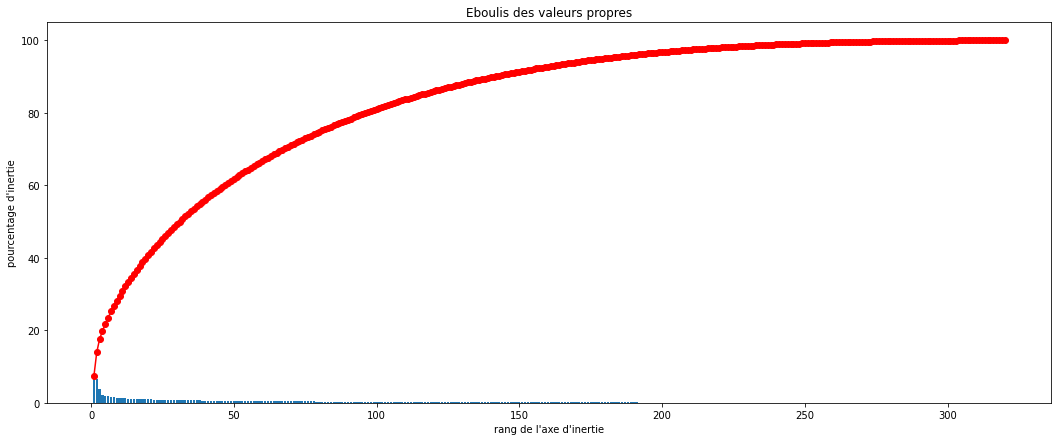

In [37]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=ACP_NB_COMPOSANTES)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

In [38]:
df_centre_reduit.head()

,0,1,2,3,4,5,6,7,8,9,...,377,378,379,380,381,382,383,384,385,386
0,0.000000,0.000000,0.011494,0.003831,0.00000,0.000000,0.007663,0.000000,0.003831,0.003831,...,0.000000,0.003831,0.007663,0.015326,0.000,0.003831,0.00000,0.0,0.003831,0.000
1,0.000000,0.014706,0.000000,0.014706,0.00000,0.000000,0.014706,0.000000,0.014706,0.000000,...,0.000000,0.000000,0.014706,0.014706,0.000,0.000000,0.00000,0.0,0.000000,0.000
2,0.005291,0.013228,0.000000,0.002646,0.00000,0.005291,0.000000,0.002646,0.000000,0.000000,...,0.005291,0.007937,0.002646,0.000000,0.000,0.002646,0.00000,0.0,0.002646,0.000
3,0.000000,0.002000,0.006000,0.002000,0.01000,0.002000,0.002000,0.016000,0.000000,0.002000,...,0.000000,0.002000,0.000000,0.000000,0.004,0.000000,0.00000,0.0,0.004000,0.002
4,0.002710,0.002710,0.002710,0.008130,0.00271,0.000000,0.000000,0.008130,0.000000,0.000000,...,0.000000,0.002710,0.000000,0.005420,0.000,0.000000,0.00271,0.0,0.000000,0.000


In [39]:
# choix du nombre de composantes à calculer
ACP_NB_COMPOSANTES = 150

axis_ranks = []

for i in range (0, ACP_NB_COMPOSANTES, 2):
    axis_ranks.append((i,i+1))

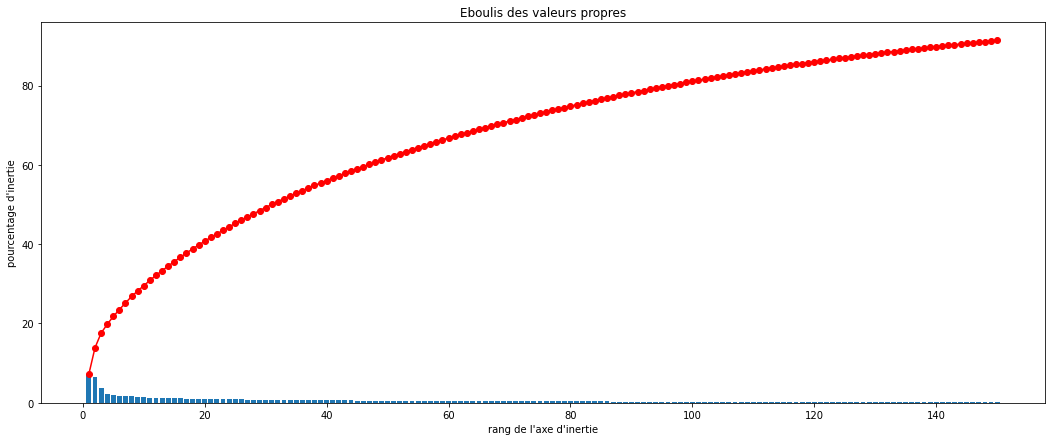

In [40]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=ACP_NB_COMPOSANTES)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

In [41]:
# Projection des individus
X_projected = pca.transform(X_scaled)
pcs = pca.components_

<div style="display: flex; background-color: Green; padding: 7px;" >

### ACP. Prédictions
</div>

In [42]:
mlp_acp = MLPClassifier(verbose=verbose, max_iter=600000)
mlp_acp.fit(X_acp, Y)
mlp_acp.score(X_acp, Y)

1.0

In [43]:
# selection des colonnes à prendre en compte dans l'ACP
df_centre_reduit_test = pd.DataFrame(X_test.copy())
print(f"{df_centre_reduit_test.isna().sum().sum()} NAN sur {df_centre_reduit_test.shape}")

# préparation des données pour l'ACP
X_acp_test = df_centre_reduit_test.values
names_test = df_centre_reduit_test.index # ou data.index pour avoir les intitulés
features_test = df_centre_reduit_test.columns

# Centrage et Réduction
std_scale_test = preprocessing.StandardScaler().fit(X_acp_test)
X_scaled_test = std_scale.transform(X_acp_test)

# calculer les composantes principales
print(f"Score test ACP : {round(mlp_acp.score(X_acp_test, Y_test),2)}")

0 NAN sur (62, 387)
Score test ACP : 0.44


<div style="display: flex; background-color: Blue; padding: 15px;" >

## 8.T-SNE
</div>

Utilisation de T-SNE pour réduire les données

In [44]:
from sklearn.manifold import TSNE

Il faut refaire l'ACP sur l'ensemble des données car le T-SNE ne peut pas être appliqué sur une sous partie, l'ensemble des données doit être traité en même temps.

In [45]:
df_centre_reduit_acp = pd.DataFrame(X_src.copy())

In [46]:
# préparation des données pour l'ACP
X_full_acp = df_centre_reduit_acp.values
features_full = df_centre_reduit_acp.columns

# Centrage et Réduction
std_scale_full = preprocessing.StandardScaler().fit(X_full_acp)
X_scaled_full = std_scale_full.transform(X_full_acp)

# calculer les composantes principales
pca_full = decomposition.PCA(n_components=ACP_NB_COMPOSANTES)
x_projeected_full = pca_full.fit_transform(X_scaled_full)

In [47]:
X_tsne = TSNE(random_state = random_state, verbose=verbose, perplexity=40, n_iter=300, init='random', learning_rate=200.0).fit_transform(x_projeected_full)

In [48]:
X_train_tsne, X_test_tsne, Y_train_tsne, Y_test_tsne = train_test_split(X_tsne, Y_src, test_size=0.2, random_state=random_state)

<div style="display: flex; background-color: Green; padding: 7px;" >

### T-SNE Prédictions
</div>

In [49]:
mlp_tsne = MLPClassifier(verbose=verbose, max_iter=600000)
mlp_tsne.fit(X_train_tsne, Y_train_tsne)
print("Train :", mlp_tsne.score(X_train_tsne, Y_train_tsne))
print("Test  :", round(mlp_tsne.score(X_test_tsne, Y_test_tsne),2))

Train : 0.58125
Test  : 0.51


<div style="display: flex; background-color: Green; padding: 7px;" >

### T-SNE Représentation
</div>

<div style="display: flex; background-color: indigo;" >

#### 2D
</div>

In [50]:
tsne = TSNE(n_components=2, init='pca', random_state=0, n_jobs=-1)
X_tsne = tsne.fit_transform(X_src)

C:\Program Files\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Program Files\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [97]:
dict_colors = {'cloudy': 'forestgreen', 'rain': 'royalblue', 'shine': 'orange', 'sunrise': 'crimson',
                0: 'forestgreen', 1: 'royalblue', 2: 'orange', 3: 'crimson'} 
y_colors = [dict_colors[yi] for yi in Y_src]

<AxesSubplot:xlabel='DIM1', ylabel='DIM2'>

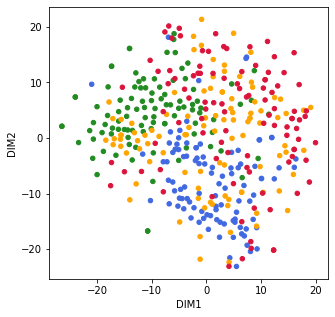

In [57]:
columns = ['DIM' + str(c) for c in range(1, X_tsne.shape[1]+1, 1)]
X_tsne = pd.DataFrame(X_tsne, columns=columns)
X_tsne.plot(x='DIM1', y='DIM2', kind='scatter', figsize=(5, 5), color=y_colors)

<div style="display: flex; background-color: indigo;" >

#### 3D
</div>

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [63]:
tsne = TSNE(n_components=3, init='pca', perplexity=45, random_state=0, n_jobs=-1)
X_tsne = tsne.fit_transform(X_src)

C:\Program Files\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Program Files\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [64]:
columns = ['DIM' + str(c) for c in range(1, X_tsne.shape[1]+1, 1)]
X_tsne = pd.DataFrame(X_tsne, columns=columns)
X_tsne.head()

,DIM1,DIM2,DIM3
0,82.404991,136.516006,38.871464
1,48.530632,11.696054,123.600601
2,-8.241326,-67.885902,81.985725
3,50.765282,-28.352209,42.788673
4,20.124119,-50.087898,-148.208115


In [65]:
X_tsne.shape

(400, 3)

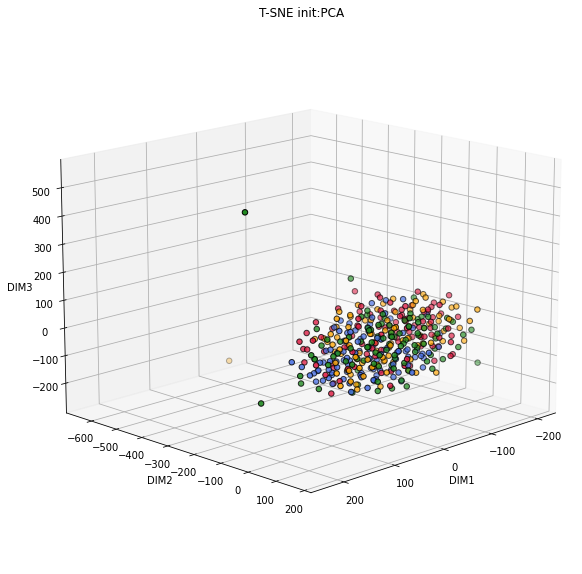

In [66]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_tsne['DIM1'], X_tsne['DIM2'], X_tsne['DIM3'], marker='o', s=30, edgecolor='k', facecolor=y_colors)
ax.set_xlabel('DIM1')
ax.set_ylabel('DIM2')
ax.set_zlabel('DIM3')
ax.set_title("T-SNE init:PCA ")
ax.view_init(elev=15, azim=45)

<div style="display: flex; background-color: Blue; padding: 15px;" >

## 11.K-MEANS - Non supervisé
</div>

In [67]:
from sklearn.cluster import KMeans

In [87]:
kmeans = KMeans(n_clusters=4, random_state=random_state).fit(X)
y_pred = kmeans.predict(X_src)
centroids = kmeans.cluster_centers_
centroids

array([[1.31558045e-03, 1.19963262e-03, 3.72410716e-03, ...,
        8.47546294e-04, 1.39962564e-03, 1.01382187e-03],
       [1.20603888e-03, 1.35051916e-03, 1.14935442e-02, ...,
        2.16840434e-19, 1.85870767e-03, 1.24750499e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.48281347e-03, 3.97098972e-03, 2.18152505e-03, ...,
        1.86317699e-03, 1.98877942e-03, 2.11746778e-03]])

In [69]:
y_pred

array([3, 3, 3, 3, 3, 0, 3, 3, 0, 0, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3,
       0, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 0,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3,
       0, 3, 3, 3, 0, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3,
       3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 0, 1, 0, 0, 3, 1, 3, 0, 3, 3, 0, 3,
       1, 1, 0, 3, 3, 3, 3, 0, 0, 1, 3, 3, 1, 0, 3, 3, 0, 3, 0, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 1, 3,
       0, 0, 3, 0, 3, 3, 0, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3, 3, 3, 3, 0, 0,
       0, 3, 3, 3, 3, 2, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 2, 1, 3, 3, 3, 0, 3, 3, 3, 3, 3,
       0, 0, 3, 1, 3, 0, 0, 0, 3, 0, 0, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 0,
       3, 3, 3, 0, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3, 3, 3,
       3, 1, 3, 3, 3, 3, 3, 3, 0, 3, 3, 1, 3, 3, 3, 0, 0, 0, 3, 3, 0, 3,
       3, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 0,

In [88]:
unique, counts = np.unique(y_pred, return_counts=True)
print (np.asarray((unique, counts)).T)
print ("sur", len(y_pred), "images, soit", round(len(y_pred)/4), "attendus par target")

[[  0  89]
 [  1  18]
 [  2   2]
 [  3 291]]
sur 400 images, soit 100 attendus par target


Représentation graphique des clusters K-Means

In [90]:
tsne_non_supervise = TSNE(n_components=3, init='pca', perplexity=45, random_state=0, n_jobs=-1)
X_tsne_non_supervise = tsne.fit_transform(X_src)
type(X_tsne_non_supervise)

C:\Program Files\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Program Files\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


numpy.ndarray

In [91]:
res_tsne = pd.DataFrame(X_tsne_non_supervise)
res_tsne["cluster"] = y_pred

In [92]:
res_tsne.head()

,0,1,2,cluster
0,82.404991,136.516006,38.871464,3
1,48.530632,11.696054,123.600601,3
2,-8.241326,-67.885902,81.985725,3
3,50.765282,-28.352209,42.788673,3
4,20.124119,-50.087898,-148.208115,3


In [93]:
res_tsne = res_tsne.rename(columns={0:"DIM_0", 1:"DIM_1", 2:"DIM_2"})
res_tsne.head()

,DIM_0,DIM_1,DIM_2,cluster
0,82.404991,136.516006,38.871464,3
1,48.530632,11.696054,123.600601,3
2,-8.241326,-67.885902,81.985725,3
3,50.765282,-28.352209,42.788673,3
4,20.124119,-50.087898,-148.208115,3


In [98]:
y_colors_kmeans = [dict_colors[yi] for yi in res_tsne["cluster"]]
y_colors_kmeans

['crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'forestgreen',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'royalblue',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'forestgreen',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'royalblue',
 'crimson',
 'royalblue',
 'royalblue',
 'crimson',
 'royalblue',
 'crimson',
 'crimson',
 'forestgreen',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'forestgreen',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 'crimson',
 '

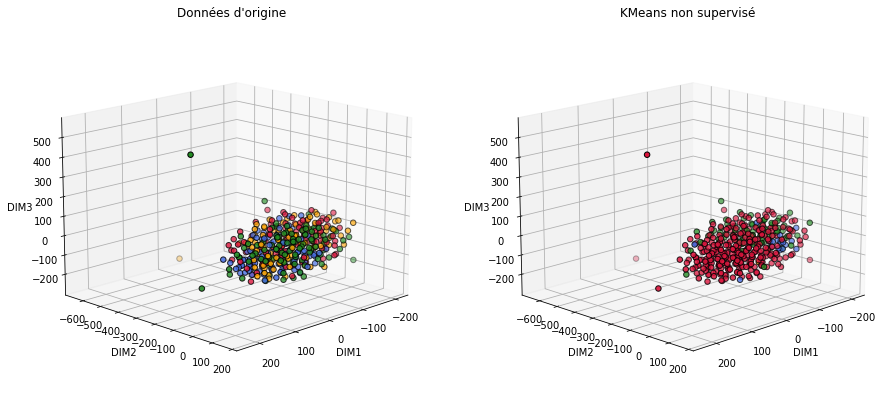

In [99]:
fig = plt.figure( figsize=(15,10))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(X_tsne['DIM1'], X_tsne['DIM2'], X_tsne['DIM3'], marker='o', s=30, edgecolor='k', facecolor=y_colors)
ax.set_xlabel('DIM1')
ax.set_ylabel('DIM2')
ax.set_zlabel('DIM3')
ax.set_title("Données d'origine")
ax.view_init(elev=15, azim=45)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(res_tsne['DIM_0'], res_tsne['DIM_1'], res_tsne['DIM_2'], marker='o', s=30, edgecolor='k', facecolor=y_colors_kmeans)
ax.set_xlabel('DIM1')
ax.set_ylabel('DIM2')
ax.set_zlabel('DIM3')
ax.set_title("KMeans non supervisé")
ax.view_init(elev=15, azim=45)



In [71]:
round(kmeans.score(X, Y),2)

-2.6

Clustering is not classification.

Note that the 'y' argument of fit is ignored. Kmeans will always predict 0,1,...,k-1. So it will never make a correct label on this data set, because it doesn't even know what a label is supposed to look like. It really doesn't work to transfer what you did in classification to clustering. You need to relearn this from scratch. Different workflow, different evaluation.

<div style="display: flex; background-color: Blue; padding: 15px;" >

## Annexes
</div>